# **Import Statements**

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils.experiment_manager import Experiment
from models.RNN_rect import EMG_RNN
from utils.data_management import Mat2TVT

%load_ext autoreload
%autoreload 2

torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

# **Data Reorganization** <br>


In [4]:
eye_bool = np.asarray([True, True, False, True, True, False, False, False])
electrode_list = ['u1', 'u2', 'u3', 'u4', 't2']
marker_list = ['u1', 'u2', 'u3', 'u4', 'u5']
filepath = 'eyeliddata.mat'

train = 0.7
val = 0.2
test = 0.1

reorganizer = Mat2TVT(eye_bool, electrode_list, marker_list, filepath)
_, _, identifier = reorganizer.load_data()
X, y = reorganizer.DMVC_norm()
TVT_dict = reorganizer.TVT_split(train, val, test)

# **Run Experiments**

In [5]:
params = {
    't_win': [0.2],
    't_stride': [5],
    't_lookahead': [50],
    'p_transform': [0.3],
    'sigma': [0.5],
    'p_mask': [0.2],
    'batch_size': [64],
    'learning_rate': [1e-3, 1e-8],
    'dropout': [0.4],
}

experiment = Experiment()
model = EMG_RNN()
best_params = experiment(params, TVT_dict, model, epochs = 2)

print("_________________________________________________________________________________________________________")
print(f"Best window size: {best_params['t_win'][0]}, Best stride size: {best_params['t_stride'][0]}, Best lookahead time: {best_params['t_lookahead'][0]}")
print(f"Best transform probability: {best_params['p_transform'][0]}, Best Jitter sigma: {best_params['sigma'][0]}, Best mask length: {best_params['p_mask'][0]}")
print(f"Best batch size: {best_params['batch_size'][0]}, Best learning rate: {best_params['learning_rate'][0]}, Best dropout probability: {best_params['dropout'][0]}")


************************************************************
Running Experiment 1 of 2
************************************************************
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 7981.4%, Avg Marker Error: 215.5%, Avg loss: 1.553927 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 7872.7%, Avg Marker Error: 208.1%, Avg loss: 1.506057 

Done!
************************************************************
Running Experiment 2 of 2
************************************************************
Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 8226.5%, Avg Marker Error: 196.3%, Avg loss: 1.604507 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 8239.9%, Avg Marker Error: 196.4%, Avg loss: 1.605268 

Done!
_________________________________________________________________________________________________________
Best window size: 0.2, Best stride size: 5, Best l

# **Training Model with Best Params**

In [6]:
metrics = experiment.run_experiment(best_params, TVT_dict, model, epochs = 20, patience = 5)

Epoch 1
-------------------------------
Validation Error: 
 Max Marker Error: 8106.9%, Avg Marker Error: 228.2%, Avg loss: 1.618699 

Epoch 2
-------------------------------
Validation Error: 
 Max Marker Error: 8058.5%, Avg Marker Error: 217.8%, Avg loss: 1.545755 

Epoch 3
-------------------------------
Validation Error: 
 Max Marker Error: 8000.7%, Avg Marker Error: 208.3%, Avg loss: 1.466216 

Epoch 4
-------------------------------
Validation Error: 
 Max Marker Error: 7935.6%, Avg Marker Error: 201.8%, Avg loss: 1.421696 

Epoch 5
-------------------------------
Validation Error: 
 Max Marker Error: 7852.3%, Avg Marker Error: 197.7%, Avg loss: 1.389668 

Epoch 6
-------------------------------
Validation Error: 
 Max Marker Error: 7755.9%, Avg Marker Error: 194.5%, Avg loss: 1.369894 

Epoch 7
-------------------------------
Validation Error: 
 Max Marker Error: 7660.1%, Avg Marker Error: 191.5%, Avg loss: 1.347523 

Epoch 8
-------------------------------
Validation Error: 
 Ma

# **Plotting Loss Metrics**

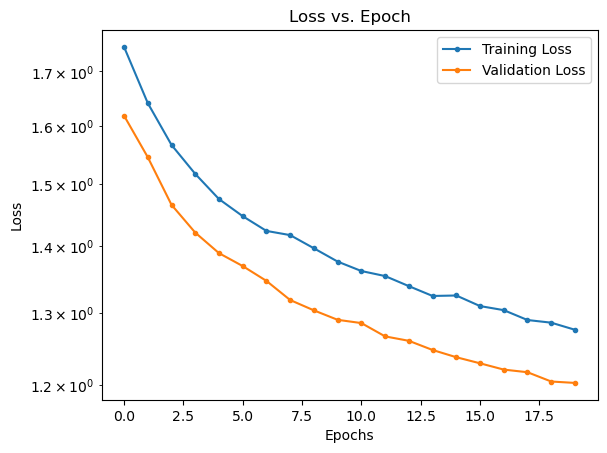

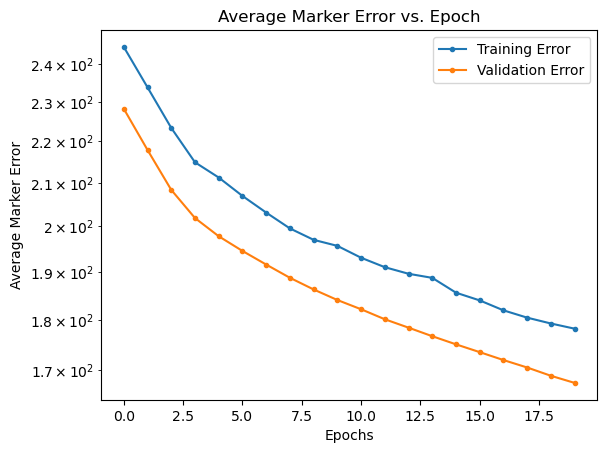

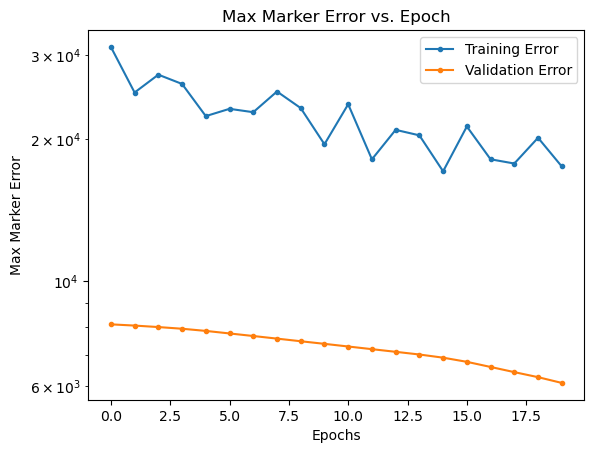

In [7]:
plt.plot(metrics['Training Loss'], label = 'Training Loss', marker = '.')
plt.plot(metrics['Validation Loss'], label = 'Validation Loss', marker = '.')
plt.yscale('log')
plt.title('Loss vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['Training Avg Marker Error'], label = 'Training Error', marker = '.')
plt.plot(metrics['Validation Avg Marker Error'], label = 'Validation Error', marker = '.')
plt.yscale('log')
plt.title('Average Marker Error vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Average Marker Error')
plt.legend()
plt.show()

plt.plot(metrics['Training Max Marker Error'], label = 'Training Error', marker = '.')
plt.plot(metrics['Validation Max Marker Error'], label = 'Validation Error', marker = '.')
plt.yscale('log')
plt.title('Max Marker Error vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Max Marker Error')
plt.legend()
plt.show()